# If we're talking about money, should we talk about REAL money?

### In this notebook we explore the validity of our previous suggestions by reassessing the methods used through the lens of inflation adjustment. More background on this approach is available in a blog post...

We'll begin this process in a similar manner to the previous questions with slight variations in the foundation of variables.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import seaborn as sns
import cpi
import warnings
warnings.filterwarnings('ignore')
cpi.update()
sns.set(style="ticks")

In [3]:
#import data and clean column names:
big_chungus = pd.read_csv('../.csv/.etl_csvs/chungus_with_tmdb.csv')
big_chungus.columns = ['Unnamed: 0', 'tconst', 'primary_title',
       'original_title', 'start_year', 'runtime_minutes',
       'averagerating', 'numvotes', 'Crime', 'War', 'Adventure', 'Biography',
       'n/a', 'News', 'Sci-Fi', 'Animation', 'Fantasy', 'Short', 'Talk-Show',
       'Thriller', 'Family', 'History', 'Horror', 'Drama', 'Reality-TV',
       'Romance', 'Music', 'Action', 'Musical', 'Western', 'Game-Show',
       'Mystery', 'Sport', 'Comedy', 'Documentary', 'Adult', 'director_1',
       'director_2', 'director_3', 'writer_1', 'writer_2', 'writer_3',
       'production_budget', 'domestic_gross', 'worldwide_gross',
       'release_date', 'genre_ids', 'id', 'original_language',
       'original_title_tmdb', 'popularity', 'release_date_tmdb', 'title',
       'vote_average', 'vote_count']
big_chungus.columns

Index(['Unnamed: 0', 'tconst', 'primary_title', 'original_title', 'start_year',
       'runtime_minutes', 'averagerating', 'numvotes', 'Crime', 'War',
       'Adventure', 'Biography', 'n/a', 'News', 'Sci-Fi', 'Animation',
       'Fantasy', 'Short', 'Talk-Show', 'Thriller', 'Family', 'History',
       'Horror', 'Drama', 'Reality-TV', 'Romance', 'Music', 'Action',
       'Musical', 'Western', 'Game-Show', 'Mystery', 'Sport', 'Comedy',
       'Documentary', 'Adult', 'director_1', 'director_2', 'director_3',
       'writer_1', 'writer_2', 'writer_3', 'production_budget',
       'domestic_gross', 'worldwide_gross', 'release_date', 'genre_ids', 'id',
       'original_language', 'original_title_tmdb', 'popularity',
       'release_date_tmdb', 'title', 'vote_average', 'vote_count'],
      dtype='object')

In [4]:
#Extract useful columns
money_chungus = big_chungus[
    ['tconst','primary_title', 'release_date',
    'domestic_gross', 'worldwide_gross','production_budget']]
money_chungus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146439 entries, 0 to 146438
Data columns (total 6 columns):
tconst               146439 non-null object
primary_title        146439 non-null object
release_date         3950 non-null object
domestic_gross       3950 non-null float64
worldwide_gross      3950 non-null float64
production_budget    3950 non-null float64
dtypes: float64(3), object(3)
memory usage: 6.7+ MB


In [5]:
#Again, we drop everything that we don't have budget/gross data for:
money_chungus.dropna(subset=['domestic_gross'], inplace=True)
money_chungus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3950 entries, 20 to 146373
Data columns (total 6 columns):
tconst               3950 non-null object
primary_title        3950 non-null object
release_date         3950 non-null object
domestic_gross       3950 non-null float64
worldwide_gross      3950 non-null float64
production_budget    3950 non-null float64
dtypes: float64(3), object(3)
memory usage: 216.0+ KB


In [6]:
#remove values with a budget or worldwide gross of zero
money_chungus = money_chungus[money_chungus.production_budget != 0]
money_chungus = money_chungus[money_chungus.worldwide_gross != 0]

In [7]:
#Let's extract the year from each release date to use in our adjustment formula:
money_chungus['year'] = pd.DatetimeIndex(money_chungus['release_date']).year

In [8]:
#Since the cpi calculator we're using uses the 2018 cpi as a benchmark, we'll revert all years after 2018 to that value of 100:
money_chungus['year'] = money_chungus['year'].replace(2019, 2018)
(money_chungus['year'] == 2019).sum()

0

In [9]:
#Now let's use the cpi module to create variables in real dollars
money_chungus['real_gross'] = money_chungus.apply(lambda x: cpi.inflate(x.worldwide_gross, x.year), axis=1)
money_chungus['real_gross'].astype(int)
money_chungus['real_budget'] = money_chungus.apply(lambda x: cpi.inflate(x.production_budget, x.year), axis=1)
money_chungus['real_budget'].astype(int)
money_chungus.head()

,tconst,primary_title,release_date,domestic_gross,worldwide_gross,production_budget,year,real_gross,real_budget
20,tt0249516,Foodfight!,2012-12-31,0.0,73706.0,45000000.0,2012,8.207294e+04,5.010830e+07
33,tt0293429,Mortal Kombat,1995-08-18,70433227.0,122133227.0,20000000.0,1995,2.048833e+08,3.355079e+07
40,tt0326592,The Overnight,2015-06-19,1109808.0,1165996.0,200000.0,2015,1.257695e+06,2.157288e+05
48,tt0337692,On the Road,2013-03-22,720828.0,9313302.0,25000000.0,2013,1.022082e+07,2.743607e+07
54,tt0359950,The Secret Life of Walter Mitty,2013-12-25,58236838.0,187861183.0,91000000.0,2013,2.061669e+08,9.986730e+07


In [10]:
# Here we'll create an roi variable AFTER adjusting for inflation:
money_chungus['real_roi'] = (money_chungus['real_gross']-money_chungus['real_budget'])/money_chungus['real_budget']

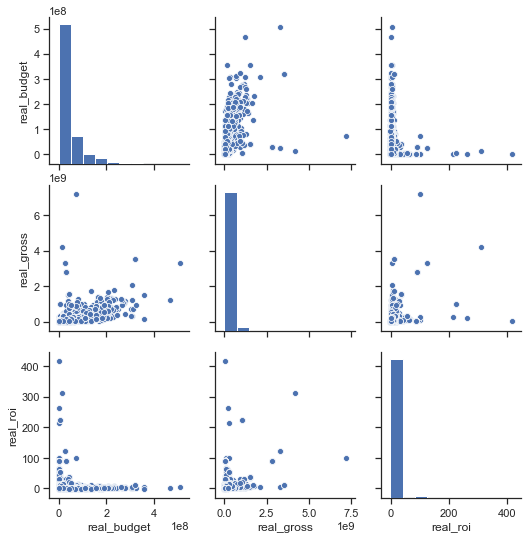

In [11]:
#We can assume that the distribution of figures is similar so let's look and see a scatter matrix on these points: 
money_table = money_chungus[['real_budget','real_gross', 'real_roi']]
sns.pairplot(money_table);

In [12]:
money_table.corr()

,real_budget,real_gross,real_roi
real_budget,1.000000,0.522558,-0.103467
real_gross,0.522558,1.000000,0.313358
real_roi,-0.103467,0.313358,1.000000


## Looks like budget and revenue have a much smaller, but still statistically significant, correlation when considering figures that are adjusted for inflation.

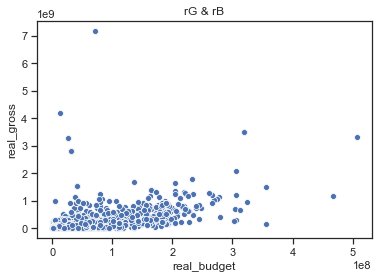

In [13]:
#The gross values really seem to flatten significantly with a perspective of inflation:
sns.scatterplot(money_chungus['real_budget'], money_chungus['real_gross']).set_title('rG & rB');

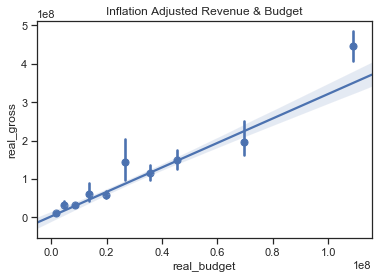

In [14]:
#Budget outliers still exist but the threshold has fallen:
sns.regplot(money_chungus['real_budget'], money_chungus['real_gross'], x_bins=10).set_title('Inflation Adjusted Revenue & Budget');


In [15]:
#To adapt to this change, the new definition for top budget can be 100 million
top_budgets = money_chungus.loc[money_chungus['real_budget'] > 100_000_000]
len(top_budgets)

375

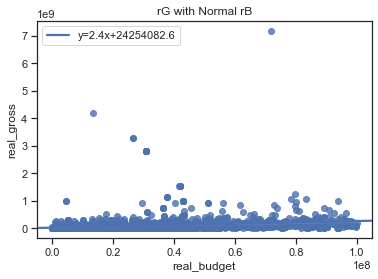

0.23648200959613785


In [16]:
normal_budgets = money_chungus.loc[money_chungus['real_budget'] < 100_000_000]
slope, intercept, r_value, p_value, std_err = stats.linregress(normal_budgets['real_budget'],normal_budgets['real_gross'])
ax = sns.regplot(x="real_budget", y="real_gross", data=normal_budgets, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.set_title('rG with Normal rB')
ax.legend()
plt.show()
print(r_value)

## Inflation adjusted figures show a much less significant connection between budget and revenue under $100 million.

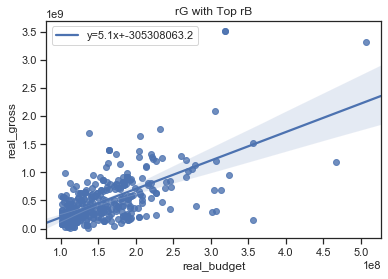

0.6262691393051816


In [17]:
#Does this hold true for big budget movies? 
slope, intercept, r_value, p_value, std_err = stats.linregress(top_budgets['real_budget'],top_budgets['real_gross'])
axtop = sns.regplot(x="real_budget", y="real_gross", data=top_budgets, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
axtop.legend()
axtop.set_title('rG with Top rB')
plt.show()
print(r_value)

## Not too surprisingly, the top movie budgets actually show a higher correlation and return when figures are adjusted for inflation.

# This is where we previously looked at ROI but a cursory analysis shows that there is little  change in the projections from the regression analysis previously established so let's check out our work with genre:

In [18]:
#Make a new dataframe from different variables:
pop_chungus = big_chungus[['tconst','primary_title', 'release_date',
    'domestic_gross', 'worldwide_gross','production_budget',
    'runtime_minutes','popularity','director_1', 'writer_1',
    'Crime', 'War','Adventure', 'Biography', 'News', 'Sci-Fi', 
    'Animation','Fantasy', 'Short', 'Talk-Show', 'Thriller', 'Family',
    'History', 'Horror', 'Drama', 'Reality-TV', 'Romance', 'Music', 'Action',
    'Musical', 'Western', 'Game-Show', 'Mystery', 'Sport', 'Comedy',
    'Documentary', 'Adult']]
pop_chungus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146439 entries, 0 to 146438
Data columns (total 37 columns):
tconst               146439 non-null object
primary_title        146439 non-null object
release_date         3950 non-null object
domestic_gross       3950 non-null float64
worldwide_gross      3950 non-null float64
production_budget    3950 non-null float64
runtime_minutes      114651 non-null float64
popularity           19272 non-null float64
director_1           140691 non-null object
writer_1             110488 non-null object
Crime                146439 non-null float64
War                  146439 non-null float64
Adventure            146439 non-null float64
Biography            146439 non-null float64
News                 146439 non-null float64
Sci-Fi               146439 non-null float64
Animation            146439 non-null float64
Fantasy              146439 non-null float64
Short                146439 non-null float64
Talk-Show            146439 non-null float64
Thr

In [19]:
#We'll have to deal with fewer entries here in order to ensure we're applying the proper date for the fiscal figures:
pop_chungus.dropna(subset=['worldwide_gross'], inplace=True)

In [20]:
# Let's extract the year and add it to this table:
pop_chungus['year'] = pd.DatetimeIndex(pop_chungus['release_date']).year


In [21]:
# Apply same procedure for cleaning recent nominal values 
pop_chungus['year'] = pop_chungus['year'].replace(2019, 2018)
pop_chungus['year'] = pop_chungus['year'].replace(2020, 2018)
(pop_chungus['year'] == 2019).sum()
pop_chungus.head()

,tconst,primary_title,release_date,domestic_gross,worldwide_gross,production_budget,runtime_minutes,popularity,director_1,writer_1,...,Action,Musical,Western,Game-Show,Mystery,Sport,Comedy,Documentary,Adult,year
20,tt0249516,Foodfight!,2012-12-31,0.0,73706.0,45000000.0,91.0,4.705,nm0440415,nm0440415,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2012
33,tt0293429,Mortal Kombat,1995-08-18,70433227.0,122133227.0,20000000.0,NaN,NaN,nm2585406,nm3859643,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1995
40,tt0326592,The Overnight,2015-06-19,1109808.0,1165996.0,200000.0,88.0,6.576,nm1208371,nm1170333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015
48,tt0337692,On the Road,2013-03-22,720828.0,9313302.0,25000000.0,124.0,8.919,nm0758574,nm0449616,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013
54,tt0359950,The Secret Life of Walter Mitty,2013-12-25,58236838.0,187861183.0,91000000.0,114.0,10.743,nm0001774,nm0175726,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2013


In [22]:
#We'll have to recalculate real values and add those columns as well:
pop_chungus['real_gross'] = pop_chungus.apply(lambda x: cpi.inflate(x.worldwide_gross, x.year), axis=1)
pop_chungus['real_gross'].astype(int)
pop_chungus['real_budget'] = pop_chungus.apply(lambda x: cpi.inflate(x.production_budget, x.year), axis=1)
pop_chungus['real_budget'].astype(int)
pop_chungus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3950 entries, 20 to 146373
Data columns (total 40 columns):
tconst               3950 non-null object
primary_title        3950 non-null object
release_date         3950 non-null object
domestic_gross       3950 non-null float64
worldwide_gross      3950 non-null float64
production_budget    3950 non-null float64
runtime_minutes      3454 non-null float64
popularity           3051 non-null float64
director_1           3856 non-null object
writer_1             3489 non-null object
Crime                3950 non-null float64
War                  3950 non-null float64
Adventure            3950 non-null float64
Biography            3950 non-null float64
News                 3950 non-null float64
Sci-Fi               3950 non-null float64
Animation            3950 non-null float64
Fantasy              3950 non-null float64
Short                3950 non-null float64
Talk-Show            3950 non-null float64
Thriller             3950 non-null 

In [23]:
# Okay, now that we have a clean table, let's apply the same approach as last go around:
col = 'real_gross'
cols = ['Crime', 'War', 'Adventure', 'Biography', 'News', 'Sci-Fi', 'Animation',
        'Fantasy', 'Thriller', 'Family', 'History', 'Horror', 'Drama', 
        'Reality-TV', 'Romance', 'Music', 'Action', 'Western', 
        'Mystery', 'Sport', 'Comedy', 'Documentary', col]
dft = pop_chungus[cols]
df_corr = dft.corr().unstack().reset_index(name='corr')
df_gross_corr = df_corr.sort_values('corr', ascending=False)[(df_corr['level_0'] == col) & (df_corr['level_1'] != col)]
df_gross_corr

,level_0,level_1,corr
508,real_gross,Adventure,0.247684
512,real_gross,Animation,0.166425
513,real_gross,Fantasy,0.144870
522,real_gross,Action,0.127591
511,real_gross,Sci-Fi,0.098950
515,real_gross,Family,0.063933
526,real_gross,Comedy,0.020055
519,real_gross,Reality-TV,-0.006471
510,real_gross,News,-0.008589
523,real_gross,Western,-0.012386


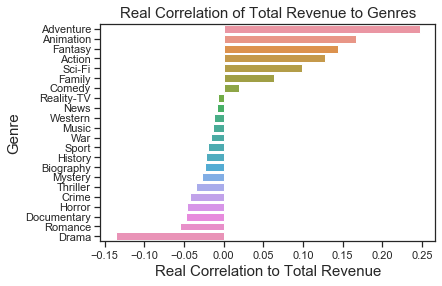

In [33]:
#Looks a little weaker than the nominal figures, let's check it out graphically:
sns.barplot(x="corr", y="level_1", data=df_gross_corr)
plt.title('Real Correlation of Total Revenue to Genres', fontsize=15)
plt.xlabel("Real Correlation to Total Revenue", fontsize=15)
plt.ylabel("Genre", fontsize=15);

In [25]:
df_gross_corr['real_percentage_schedule'] =(((df_gross_corr['corr'] + 0.135993769626171)*100)/3.350269113).round(1)


## Looks like the scale of lost revenue hasn't changed much but there's less positive correlation with revenue when figures are adjusted for inflation. Small differences in correlation that yield further discussion in the associate blog post. 

In [26]:
#Let's rebuild our previous table and merge them so we can compare:
og_col = 'worldwide_gross'
og_cols = ['Crime', 'War', 'Adventure', 'Biography', 'News', 'Sci-Fi', 'Animation',
        'Fantasy', 'Thriller', 'Family', 'History', 'Horror', 'Drama', 
        'Reality-TV', 'Romance', 'Music', 'Action', 'Western', 
        'Mystery', 'Sport', 'Comedy', 'Documentary', og_col]
og_dft = pop_chungus[og_cols]
og_df_corr = og_dft.corr().unstack().reset_index(name='corr')
og_df_gross_corr = og_df_corr.sort_values('corr', ascending=False)[(og_df_corr['level_0'] == og_col) & (og_df_corr['level_1'] != og_col)]
og_df_gross_corr

,level_0,level_1,corr
508,worldwide_gross,Adventure,0.385612
522,worldwide_gross,Action,0.217526
512,worldwide_gross,Animation,0.217247
511,worldwide_gross,Sci-Fi,0.167770
513,worldwide_gross,Fantasy,0.122174
515,worldwide_gross,Family,0.042218
526,worldwide_gross,Comedy,0.032673
519,worldwide_gross,Reality-TV,-0.007777
510,worldwide_gross,News,-0.010602
523,worldwide_gross,Western,-0.014542


In [27]:
og_df_gross_corr['nominal_percentage_schedule'] =(((df_gross_corr['corr'] + 0.164351962)*100)/4.23).round(1)

In [28]:
combo_corr = df_gross_corr.merge(og_df_gross_corr, on= 'level_1')
combo_corr['delta'] = combo_corr['corr_x'] - combo_corr['corr_y']
combo_corr = combo_corr.sort_values('delta', ascending=False)




In [29]:
combo_corr.head()

,level_0_x,level_1,corr_x,real_percentage_schedule,level_0_y,corr_y,nominal_percentage_schedule,delta
21,real_gross,Drama,-0.135994,-0.0,worldwide_gross,-0.164352,0.7,0.028358
19,real_gross,Documentary,-0.047066,2.7,worldwide_gross,-0.073200,2.8,0.026134
2,real_gross,Fantasy,0.144870,8.4,worldwide_gross,0.122174,7.3,0.022696
5,real_gross,Family,0.063933,6.0,worldwide_gross,0.042218,5.4,0.021715
10,real_gross,Music,-0.013505,3.7,worldwide_gross,-0.025790,3.6,0.012285


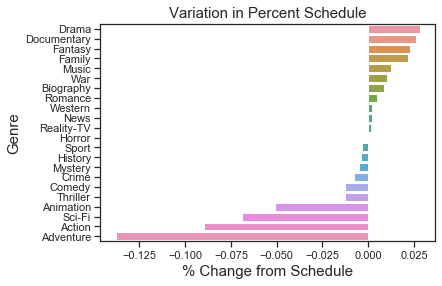

In [30]:
sns.barplot(x="delta", y="level_1", data=combo_corr)
plt.title('Variation in Percent Schedule', fontsize=15)
plt.xlabel("% Change from Schedule", fontsize=15)
plt.ylabel("Genre", fontsize=15);

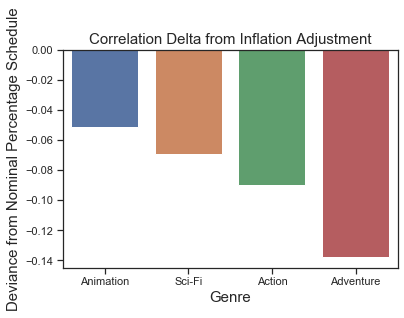

In [31]:
top_delta = ['Animation', 'Adventure', 'Action', 'Sci-Fi', ]
graphable = combo_corr[combo_corr.level_1.isin(top_delta)]
sns.barplot(x="level_1", y="delta", data=graphable)
plt.title('Correlation Delta from Inflation Adjustment', fontsize=15)
plt.xlabel("Genre", fontsize=15)
plt.ylabel("Deviance from Nominal Percentage Schedule", fontsize=15);

In [35]:
graphable.head()

,level_0_x,level_1,corr_x,real_percentage_schedule,level_0_y,corr_y,nominal_percentage_schedule,delta
1,real_gross,Animation,0.166425,9.0,worldwide_gross,0.217247,7.8,-0.050822
4,real_gross,Sci-Fi,0.098950,7.0,worldwide_gross,0.167770,6.2,-0.068819
3,real_gross,Action,0.127591,7.9,worldwide_gross,0.217526,6.9,-0.089935
0,real_gross,Adventure,0.247684,11.5,worldwide_gross,0.385612,9.7,-0.137928


In [36]:
graphable = graphable[
     ['level_1','level_0_x', 'real_percentage_schedule',
     'nominal_percentage_schedule', 'level_0_y','delta']]
graphable['genre'] = graphable['level_1']

In [45]:
test =  graphable.melt(id_vars = ['genre'], value_vars =['nominal_percentage_schedule','real_percentage_schedule'])
test['variable'] = test['variable'].replace('nominal_percentage_schedule', 'Nominal')
test['variable'] = test['variable'].replace('real_percentage_schedule', 'Inflation Adjusted')
test

,genre,variable,value
0,Animation,Nominal,7.8
1,Sci-Fi,Nominal,6.2
2,Action,Nominal,6.9
3,Adventure,Nominal,9.7
4,Animation,Inflation Adjusted,9.0
5,Sci-Fi,Inflation Adjusted,7.0
6,Action,Inflation Adjusted,7.9
7,Adventure,Inflation Adjusted,11.5


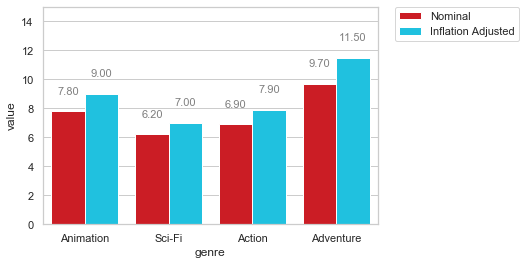

In [46]:
sns.set(style="whitegrid", palette="bright", color_codes=True)
g = sns.barplot(x="genre", y="value", hue="variable",
               palette={"Nominal": "r", "Inflation Adjusted": "c"},
               data= test)
ax=g
for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                 textcoords='offset points')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
_ = g.set_ylim(0,15);